### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from utils.metrics import psnr, ssim, ms_ssim, vif
import lpips

2022-12-16 21:27:35.367901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
import scipy

### Load example images

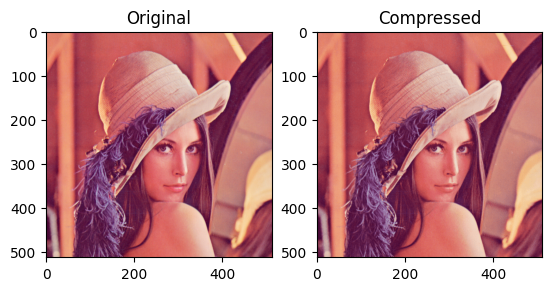

In [125]:
test_img = mpimg.imread('test_image.png')
comp_img = mpimg.imread('compressed_image.png')[:,:,:3]
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.gca().set_title("Original")
plt.subplot(1,2,2)
plt.imshow(comp_img)
plt.gca().set_title("Compressed")
plt.show()

### Run the metrics

In [5]:
def gaussian(window_size, sigma):
    """
    Generate a normalized tensor with values drawn from Gaussian distribution with standord deviation sigma
    """    
    gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/(2*sigma**2)) for x in range(window_size)])
    gauss = gauss / gauss.sum()
    return gauss


def create_window(window_size, channel=1):
    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window


def ms_ssim(img0, img1, C1=0.01**2, C2=0.03**2, val_range=255, window_size=11):
    """
    Mean Structural Similarity Index. Assuming alpha = beta = gamma = 1 for better form
    """
    pad = window_size // 2
    img0 = torch.from_numpy(img0).type(torch.FloatTensor)
    img1 = torch.from_numpy(img1).type(torch.FloatTensor)
    
    channels, height, width = img1.size()

    real_size = min(window_size, height, width) 
    window = create_window(real_size, channel=channels)
    
    # luminance calculated with convolutional sliding windows
    mu0 = F.conv2d(img0, window, padding=pad, groups=channels)
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)

    # Contrast calculated with convolutional sliding windows
    var0 = F.conv2d(img0 * img0, window, padding=pad, groups=channels) - mu0**2
    var1 = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1**2 
    var01 =  F.conv2d(img0 * img1, window, padding=pad, groups=channels) - mu0*mu1 

    ssim_score = ((2*mu0*mu1 + C1) * (2 * var01 + C2)) / ((mu0**2 + mu1**2  + C1) * (var0 + var1 + C2))
    
    return ssim_score.mean().item()

In [6]:
loss_fn = lpips.LPIPS(net='alex')
def run_metrics(test_img, comp_img):
    ### PSNR
    psnr_score = psnr(test_img, comp_img)

    ### SSIM and MS-SSIM
    ssim_score = ssim(test_img, comp_img)
    ms_ssim_score = ms_ssim(test_img, comp_img)

    ### VIF
    vif_score = vif(test_img, comp_img)

    ### LPIPS
    lpips_score = loss_fn(torch.from_numpy(test_img).unsqueeze(0).permute(0, 3, 1, 2), 
                          torch.from_numpy(comp_img).unsqueeze(0).permute(0, 3, 1, 2)).item()
    
    return psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score

def get_metrics_text(psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score):
    return f'PSNR: {psnr_score}\nSSIM: {ssim_score}\nMS-SSIM: {ms_ssim_score}\nVIF: {vif_score}\nLPIPS:{lpips_score}'

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/envs/ee274_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ee274_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/envs/ee274_env/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [7]:
psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score = run_metrics(test_img, comp_img)
print(get_metrics_text(psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score))

/var/folders/ct/xkgkks4518s3spw_rb7jw91h0000gn/T/ipykernel_41839/3234035855.py:27: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:205.)
  img0 = torch.from_numpy(img0).type(torch.FloatTensor)


PSNR: 31.156191733985963
SSIM: 2.9743873578712554
MS-SSIM: 0.9898914694786072
VIF: 1.0224043172647428
LPIPS:0.08465027064085007


### Dataset verification

In [8]:
import os
ref_distorted_dict = {}
for ref in [img_name.split('.')[0].lower() for img_name in os.listdir("tid2013/reference_images")]:
    ref_distorted_dict[ref] = []
for dis in os.listdir("tid2013/distorted_images"):
    ref = dis.split('.')[0].split('_')[0].lower()
    ref_distorted_dict[ref].append(dis)

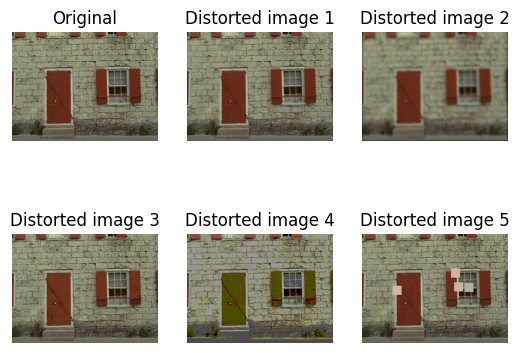

image 1
PSNR: 31.156191733985963
SSIM: 2.9743873578712554
MS-SSIM: 0.9898914694786072
VIF: 1.0224043172647428
LPIPS:0.08465027064085007
############
image 2
PSNR: 28.3758488262092
SSIM: 2.8120498892523185
MS-SSIM: 0.9578168392181396
VIF: 0.9736843517784873
LPIPS:0.2660161852836609
############
image 3
PSNR: 29.482597135223735
SSIM: 2.981759239965148
MS-SSIM: 0.9831691980361938
VIF: 0.9944126275400914
LPIPS:0.019489051774144173
############
image 4
PSNR: 27.5601169145124
SSIM: 2.871050588240807
MS-SSIM: 0.9053674340248108
VIF: 0.9201576298055245
LPIPS:0.13230517506599426
############
image 5
PSNR: 43.989170214469375
SSIM: 2.9359478467988867
MS-SSIM: 0.9954020977020264
VIF: 0.9917158693209771
LPIPS:0.030823279172182083
############


In [9]:
test_img = mpimg.imread('tid2013/reference_images/I01.bmp')
comps = ["i01_08_2.bmp", "i01_08_5.bmp", "i01_07_2.bmp", "i01_07_5.bmp", "i01_15_4.bmp"]
scores = []
score_texts = []
plt.subplot(2,3,1)
plt.axis('off')
plt.imshow(test_img)
plt.gca().set_title("Original")
for i, comp in enumerate(comps):
    comp_img = mpimg.imread(os.path.join("tid2013/distorted_images", comp))[:,:,:3]
    psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score = run_metrics(test_img, comp_img)
    txt = get_metrics_text(psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score)
    scores.append((psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score))
    score_texts.append(txt)
    plt.subplot(2,3,2+i)
    
    plt.imshow(comp_img)
    plt.axis('off')
    plt.gca().set_title(f'Distorted image {i+1}')
plt.show()
for i in range(len(scores)):
    print(f'image {i+1}')
    print(score_texts[i])
    print("############")

### API Testing

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/envs/ee274_env/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


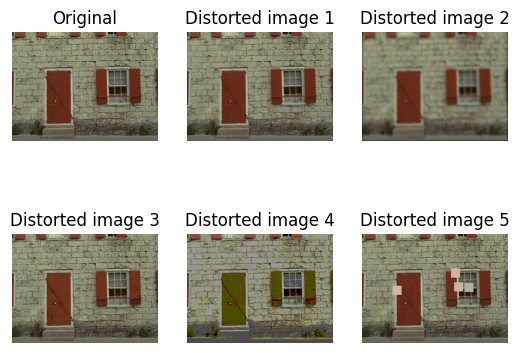

image 1
PSNR: 31.156191733985963
SSIM: 2.9743873578712554
MS-SSIM: 0.9898914694786072
VIF: 1.0224043172647428
LPIPS:0.08465027064085007
############
image 2
PSNR: 28.3758488262092
SSIM: 2.8120498892523185
MS-SSIM: 0.9578168392181396
VIF: 0.9736843517784873
LPIPS:0.2660161852836609
############
image 3
PSNR: 29.482597135223735
SSIM: 2.981759239965148
MS-SSIM: 0.9831691980361938
VIF: 0.9944126275400914
LPIPS:0.019489051774144173
############
image 4
PSNR: 27.5601169145124
SSIM: 2.871050588240807
MS-SSIM: 0.9053674340248108
VIF: 0.9201576298055245
LPIPS:0.13230517506599426
############
image 5
PSNR: 43.989170214469375
SSIM: 2.9359478467988867
MS-SSIM: 0.9954020977020264
VIF: 0.9917158693209771
LPIPS:0.030823279172182083
############


In [12]:
from utils.metrics import ImageQualityMetrics
metrics = ImageQualityMetrics()
test_img = mpimg.imread('tid2013/reference_images/I01.bmp')
comps = ["i01_08_2.bmp", "i01_08_5.bmp", "i01_07_2.bmp", "i01_07_5.bmp", "i01_15_4.bmp"]
scores = []
score_texts = []
plt.subplot(2,3,1)
plt.axis('off')
plt.imshow(test_img)
plt.gca().set_title("Original")
for i, comp in enumerate(comps):
    comp_img = mpimg.imread(os.path.join("tid2013/distorted_images", comp))[:,:,:3]
    metrics.evaluate(test_img, comp_img)
    txt = metrics.get_metrics_text()
    metrics_scores = metrics.get_metrics()
    scores.append((
        metrics_scores["psnr"], metrics_scores["ssim"], metrics_scores["ms-ssim"], metrics_scores["vif"], metrics_scores["lpips"]))
    score_texts.append(txt)
    plt.subplot(2,3,2+i)
    
    plt.imshow(comp_img)
    plt.axis('off')
    plt.gca().set_title(f'Distorted image {i+1}')
plt.show()
for i in range(len(scores)):
    print(f'image {i+1}')
    print(score_texts[i])
    print("############")

### Experiments

#### Different Compression Approaches

In [220]:
original = mpimg.imread('examples/kodim15_originals.png')
jpegs = [mpimg.imread('examples/kodim15_jpg_1x.jpg'),
        mpimg.imread('examples/kodim15_jpg_2x.jpg'),
        mpimg.imread('examples/kodim15_jpg_3x.jpg'),
        mpimg.imread('examples/kodim15_jpg_4x.jpg')]
bpgs = [mpimg.imread('examples/kodim15_bpg_1x.png'),
       mpimg.imread('examples/kodim15_bpg_2x.png'),
       mpimg.imread('examples/kodim15_bpg_3x.png'),]
hific = mpimg.imread('examples/kodim15_HiFiC_Lo.png')

##### JPEG

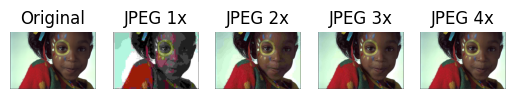

JPEG 1x
PSNR: -42.695956230163574
SSIM: 0.985919376112283
MS-SSIM: 0.5496845245361328
VIF: 707.5428599411781
LPIPS:0.8261496424674988
############
JPEG 2x
PSNR: -42.5811767578125
SSIM: 1.0089298039213848
MS-SSIM: 0.5491958260536194
VIF: 967.3727573543698
LPIPS:0.7379969358444214
############
JPEG 3x
PSNR: -42.5830078125
SSIM: 1.0116610853781645
MS-SSIM: 0.5491911172866821
VIF: 992.0052835661686
LPIPS:0.7001295685768127
############
JPEG 4x
PSNR: -42.583680152893066
SSIM: 1.0127528555257497
MS-SSIM: 0.5491905808448792
VIF: 997.4729877789765
LPIPS:0.6868131756782532
############


In [221]:
scores = []
score_texts = []
plt.subplot(1,5,1)
plt.axis('off')
plt.imshow(original)
plt.gca().set_title("Original")
for i, comp in enumerate(jpegs):
    psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score = run_metrics(original, comp)
    txt = get_metrics_text(psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score)
    scores.append((psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score))
    score_texts.append(txt)
    plt.subplot(1,5,2+i)
    plt.imshow(comp)
    plt.axis('off')
    plt.gca().set_title(f'JPEG {i+1}x')
plt.show()
for i in range(len(scores)):
    print(f'JPEG {i+1}x')
    print(score_texts[i])
    print("############")

##### BPG

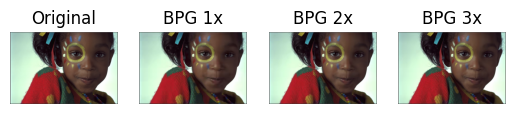

BPG 1x
PSNR: 31.372675895690918
SSIM: 2.9972927040679114
MS-SSIM: 0.988721489906311
VIF: 0.9105554973426566
LPIPS:0.16598954796791077
############
BPG 2x
PSNR: 33.69544982910156
SSIM: 2.9984173966424095
MS-SSIM: 0.9922284483909607
VIF: 0.9470590181187759
LPIPS:0.10349766910076141
############
BPG 3x
PSNR: 34.892780780792236
SSIM: 2.998799719943516
MS-SSIM: 0.9936276078224182
VIF: 0.9590416577415077
LPIPS:0.08366409689188004
############


In [146]:
scores = []
score_texts = []
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(original)
plt.gca().set_title("Original")
for i, comp in enumerate(bpgs):
    psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score = run_metrics(original, comp)
    txt = get_metrics_text(psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score)
    scores.append((psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score))
    score_texts.append(txt)
    plt.subplot(1,4,2+i)
    plt.imshow(comp)
    plt.axis('off')
    plt.gca().set_title(f'BPG {i+1}x')
plt.show()
for i in range(len(scores)):
    print(f'BPG {i+1}x')
    print(score_texts[i])
    print("############")

##### HiFiC

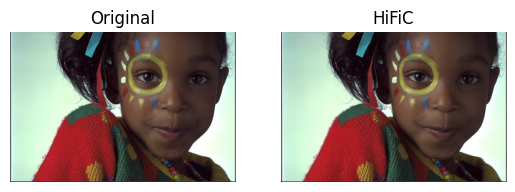

HiFiC
PSNR: 29.30522918701172
SSIM: 2.995657278369782
MS-SSIM: 0.9850403666496277
VIF: 0.9260129628745236
LPIPS:0.03765713796019554


In [149]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(original)
plt.gca().set_title("Original")

psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score = run_metrics(original, hific)
txt = get_metrics_text(psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score)
plt.subplot(1,2,2)
plt.imshow(hific)
plt.axis('off')
plt.gca().set_title(f'HiFiC')
plt.show()

print(f'HiFiC')
print(txt)

#### Different types of distortion

In [163]:
num_originals = len(os.listdir("tid2013/reference_images"))
num_types = 24
num_each = 5
distortion_dict = {type_id : {ori : [] for ori in range(1, num_originals+1)} 
                   for type_id in range(1, num_types+1)}
for file in list(sorted(os.listdir("tid2013/distorted_images"))):
    ori = int(file.split('_')[0][1:])
    type_id = int(file.split('_')[1])
    distortion_dict[type_id][ori].append(file)

In [195]:
psnr_scores = np.zeros((num_types, num_originals, num_each))
ssim_scores = np.zeros((num_types, num_originals, num_each))
ms_ssim_scores = np.zeros((num_types, num_originals, num_each))
vif_scores = np.zeros((num_types, num_originals, num_each))
lpips_scores = np.zeros((num_types, num_originals, num_each))
for type_id, ori_dis in distortion_dict.items():
    for ori_id, dis_list in ori_dis.items():
        for dis in dis_list:
            dis_id = int(dis.split('_')[-1][0])
            ori_img = mpimg.imread(f'tid2013/reference_images/I{str(ori_id).zfill(2)}.BMP')
            comp_img = mpimg.imread(f'tid2013/distorted_images/{dis}')
            psnr_score, ssim_score, ms_ssim_score, vif_score, lpips_score = run_metrics(ori_img, comp_img)
            psnr_scores[type_id-1][ori_id-1][dis_id-1] = psnr_score
            ssim_scores[type_id-1][ori_id-1][dis_id-1] = ssim_score
            ms_ssim_scores[type_id-1][ori_id-1][dis_id-1] = ms_ssim_score
            vif_scores[type_id-1][ori_id-1][dis_id-1] = vif_score
            lpips_scores[type_id-1][ori_id-1][dis_id-1] = lpips_score
        print(f'Finished {type_id} {ori_id}')

Finished 1 1
Finished 1 2
Finished 1 3
Finished 1 4
Finished 1 5
Finished 1 6
Finished 1 7
Finished 1 8
Finished 1 9
Finished 1 10
Finished 1 11
Finished 1 12
Finished 1 13
Finished 1 14
Finished 1 15
Finished 1 16
Finished 1 17
Finished 1 18
Finished 1 19
Finished 1 20
Finished 1 21
Finished 1 22
Finished 1 23
Finished 1 24
Finished 1 25
Finished 2 1
Finished 2 2
Finished 2 3
Finished 2 4
Finished 2 5
Finished 2 6
Finished 2 7
Finished 2 8
Finished 2 9
Finished 2 10
Finished 2 11
Finished 2 12
Finished 2 13
Finished 2 14
Finished 2 15
Finished 2 16
Finished 2 17
Finished 2 18
Finished 2 19
Finished 2 20
Finished 2 21
Finished 2 22
Finished 2 23
Finished 2 24
Finished 2 25
Finished 3 1
Finished 3 2
Finished 3 3
Finished 3 4
Finished 3 5
Finished 3 6
Finished 3 7
Finished 3 8
Finished 3 9
Finished 3 10
Finished 3 11
Finished 3 12
Finished 3 13
Finished 3 14
Finished 3 15
Finished 3 16
Finished 3 17
Finished 3 18
Finished 3 19
Finished 3 20
Finished 3 21
Finished 3 22
Finished 3 23
Finis

Finished 24 1
Finished 24 2
Finished 24 3
Finished 24 4
Finished 24 5
Finished 24 6
Finished 24 7
Finished 24 8
Finished 24 9
Finished 24 10
Finished 24 11
Finished 24 12
Finished 24 13
Finished 24 14
Finished 24 15
Finished 24 16
Finished 24 17
Finished 24 18
Finished 24 19
Finished 24 20
Finished 24 21
Finished 24 22
Finished 24 23
Finished 24 24
Finished 24 25


In [247]:
psnr_std = np.var(10**(psnr_scores/20), axis=(1,2))
# psnr_std = np.var(psnr_scores, axis=(1,2))
ssim_std = np.var(ssim_scores, axis=(1,2))
ms_ssim_std = np.var(ms_ssim_scores, axis=(1,2))
vif_std = np.var(vif_scores, axis=(1,2))
lpips_std = np.var(lpips_scores, axis=(1,2))

Text(0.5, 1.0, 'Variance of metrics for different distortion types')

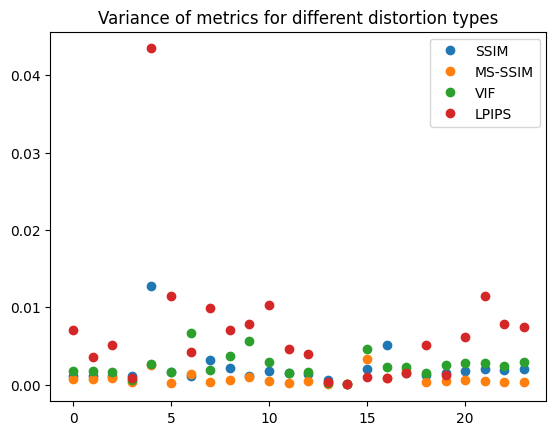

In [251]:
# plt.plot(range(num_types), psnr_std, 'o', label = "PSNR")
plt.plot(range(num_types), ssim_std, 'o', label = "SSIM")
plt.plot(range(num_types), ms_ssim_std, 'o', label = "MS-SSIM")
plt.plot(range(num_types), vif_std, 'o', label = "VIF")
plt.plot(range(num_types), lpips_std, 'o', label = "LPIPS")
# plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
# plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
# plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
# plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Variance of metrics for different distortion types")

Text(0.5, 1.0, 'Gaussian Noise')

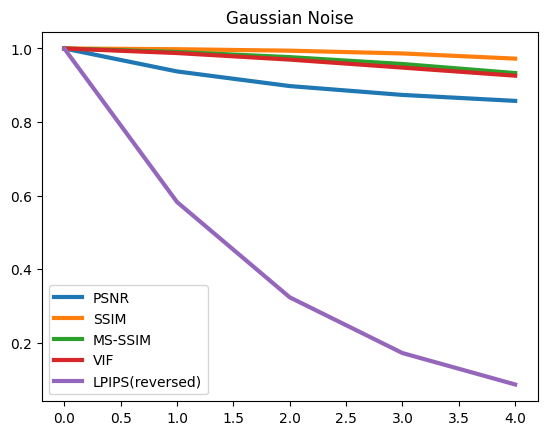

In [212]:
type_id = 0
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Gaussian Noise")


Text(0.5, 1.0, 'Gaussian Blur')

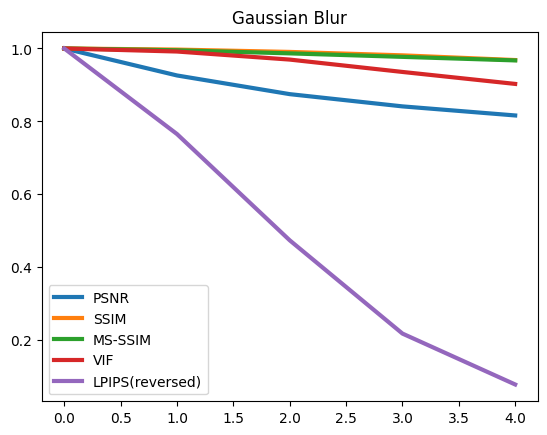

In [219]:
type_id = 7
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Gaussian Blur")


Text(0.5, 1.0, 'JPEG compression')

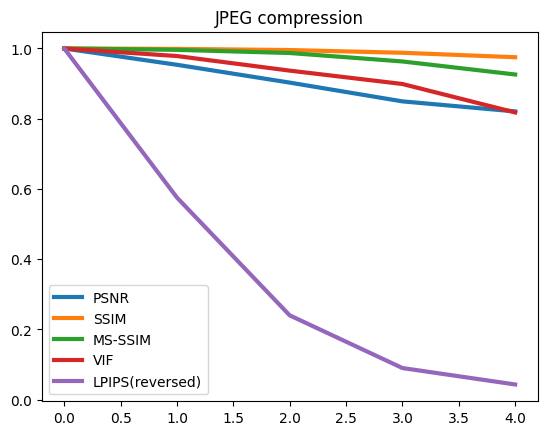

In [222]:
type_id = 9
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("JPEG compression")


In [224]:
np.mean(psnr_scores[10], axis=0)

array([34.47369582, 32.77373909, 31.40055184, 30.25813085, 29.22825471])

Text(0.5, 1.0, 'Luminance shift')

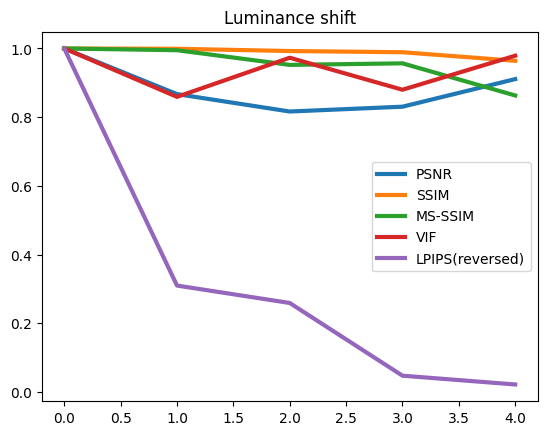

In [214]:
type_id = 15
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Luminance shift")


Text(0.5, 1.0, 'Contrast change')

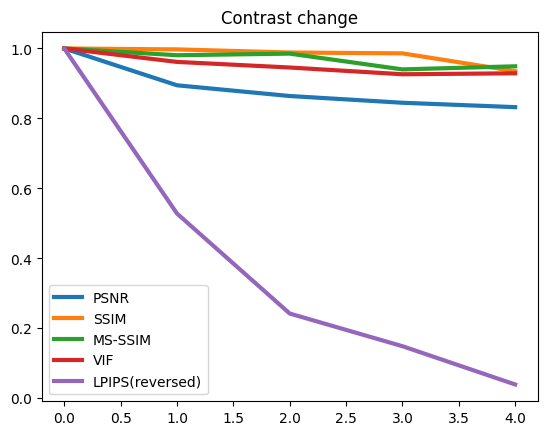

In [216]:
type_id = 16
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Contrast change")


Text(0.5, 1.0, 'Lossy compression of noisy images')

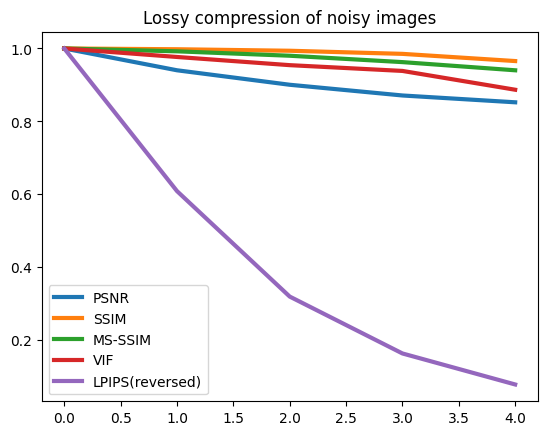

In [217]:
type_id = 20
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Lossy compression of noisy images")


Text(0.5, 1.0, 'Quantization')

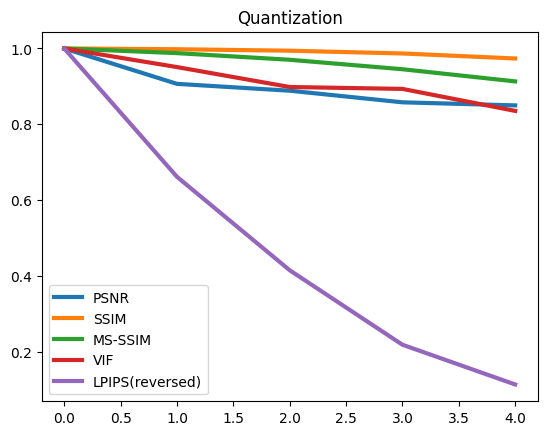

In [218]:
type_id = 6
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Quantization")


Text(0.5, 1.0, 'Sparse sample and reconstruction')

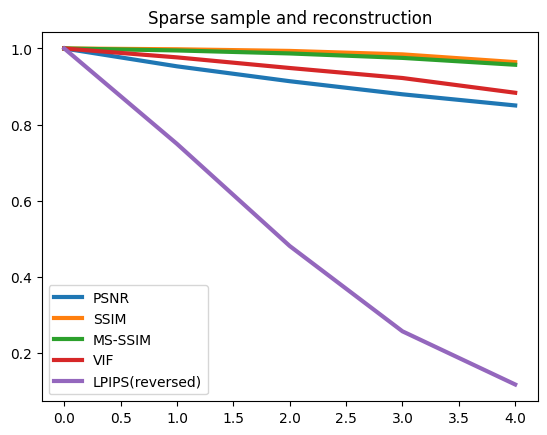

In [252]:
type_id = 23
plt.plot(range(5), np.mean(psnr_scores[type_id], axis=0) / np.max(np.mean(psnr_scores[type_id], axis=0)), label = "PSNR", linewidth=3)
plt.plot(range(5), np.mean(ssim_scores[type_id], axis=0) / np.max(np.mean(ssim_scores[type_id], axis=0)), label = "SSIM", linewidth=3)
plt.plot(range(5), np.mean(ms_ssim_scores[type_id], axis=0) / np.max(np.mean(ms_ssim_scores[type_id], axis=0)), label = "MS-SSIM", linewidth=3)
plt.plot(range(5), np.mean(vif_scores[type_id], axis=0) / np.max(np.mean(vif_scores[type_id], axis=0)), label = "VIF", linewidth=3)
plt.plot(range(5), (np.mean(lpips_scores[type_id], axis=0) / np.max(np.mean(lpips_scores[type_id], axis=0)))[::-1], label = "LPIPS(reversed)", linewidth=3)
plt.legend()
plt.title("Sparse sample and reconstruction")
